##### Copyright 2025 Google LLC.

In [1]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Agentic framework for Telecom Billing Anolamies 



## Core Concept & Value

The Agentic AI Billing Anomaly Investigation System is a multi-agent, LLM-powered workflow that automatically investigates customer billing issues by orchestrating multiple specialized AI agents connected to telecom backend systems. Instead of manually analyzing bills, cross-checking usage, and validating charges, the system performs a full anomaly investigation and presents a simple, friendly explanation to the end customer.

#### Core Value
* Instant query resolution → Reduces load on call centers and customer support teams.
* High accuracy through multi-agent specialization → Billing, usage analytics, plan validation, and reasoning agents work together.
* Improved customer trust → Transparent breakdown of usage and reasons for charges.
* Operator efficiency → Automated cross-system investigations that normally require human SME intervention
* Enterprise-ready → Observability, tool orchestration, memory, and state management built in using Google ADK.

## The Problem

Telecom billing is inherently complex due to:
* Varied plan entitlements
* Data, voice, SMS, and roaming usage
* Time-based or event-based charging
* Frequent customer movement across networks
* Third-party VAS charges
* Disputes caused by anomalies, incorrect usage estimation, or roaming events

As a result:

#### Challenges
* Customers often don’t understand unexpected charges.
* Support teams spend time-consuming effort manually investigating bills.
* Investigations require pulling data from multiple telecom systems (billing, CRM, OCS, usage analytics).
* Incorrect or opaque explanations reduce customer satisfaction.
* High dependency on human experts leads to inconsistent responses.

## The Solution
A multi-agent, LLM-driven investigation workflow where each agent performs a specific telecom task:

### ✔ Billing Agent
Fetches the bill, extracts usage patterns and charges.

### ✔ Usage Anomaly Agent
Runs analytics to detect unusual consumption or roaming usage.

### ✔ Plan Agent
Maps current plan entitlements to bill components to detect mismatches.

### ✔ LLM Planner + Orchestrator
Coordinates sequential + parallel flows, executes tools, and aggregates results.

### ✔ Customer-Facing Agent
Converts technical findings into a simple, empathetic explanation and provides next steps.

### ✔ Observability + Memory
Tracks investigations, supports audit logs, and enables personalization.

### Outcome
A unified system that conducts a complete anomaly investigation in seconds and responds to customers with clear, accurate billing insights.

## The Architecture

#### Architecture Diagram — High-Level Flow

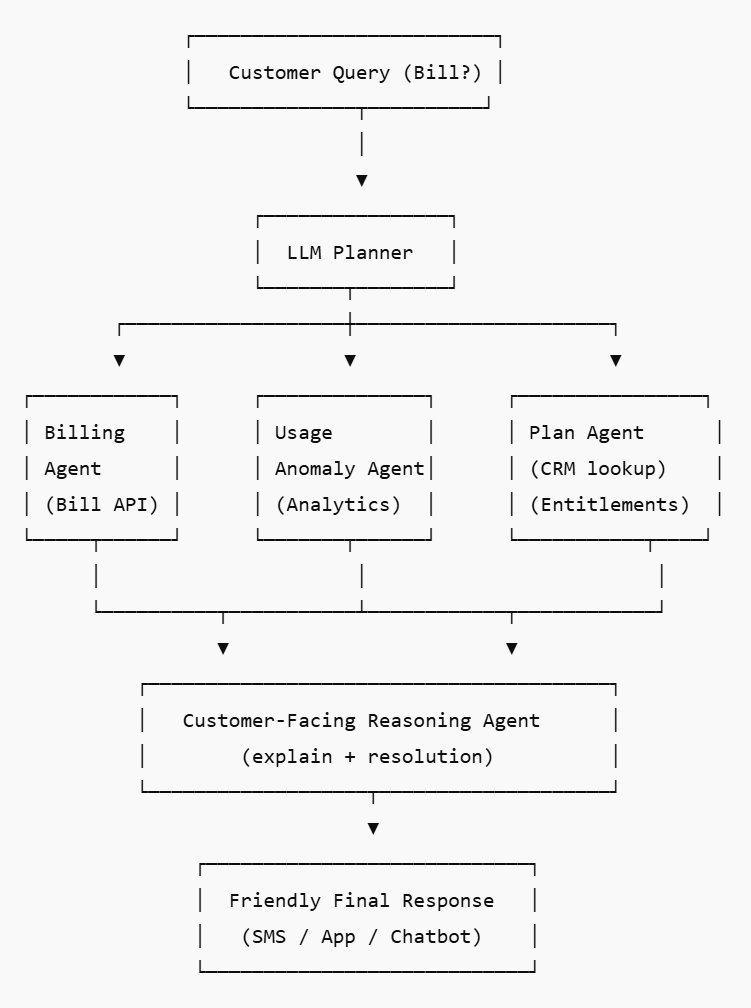


#### Detailed Agent-Orchestration Diagram

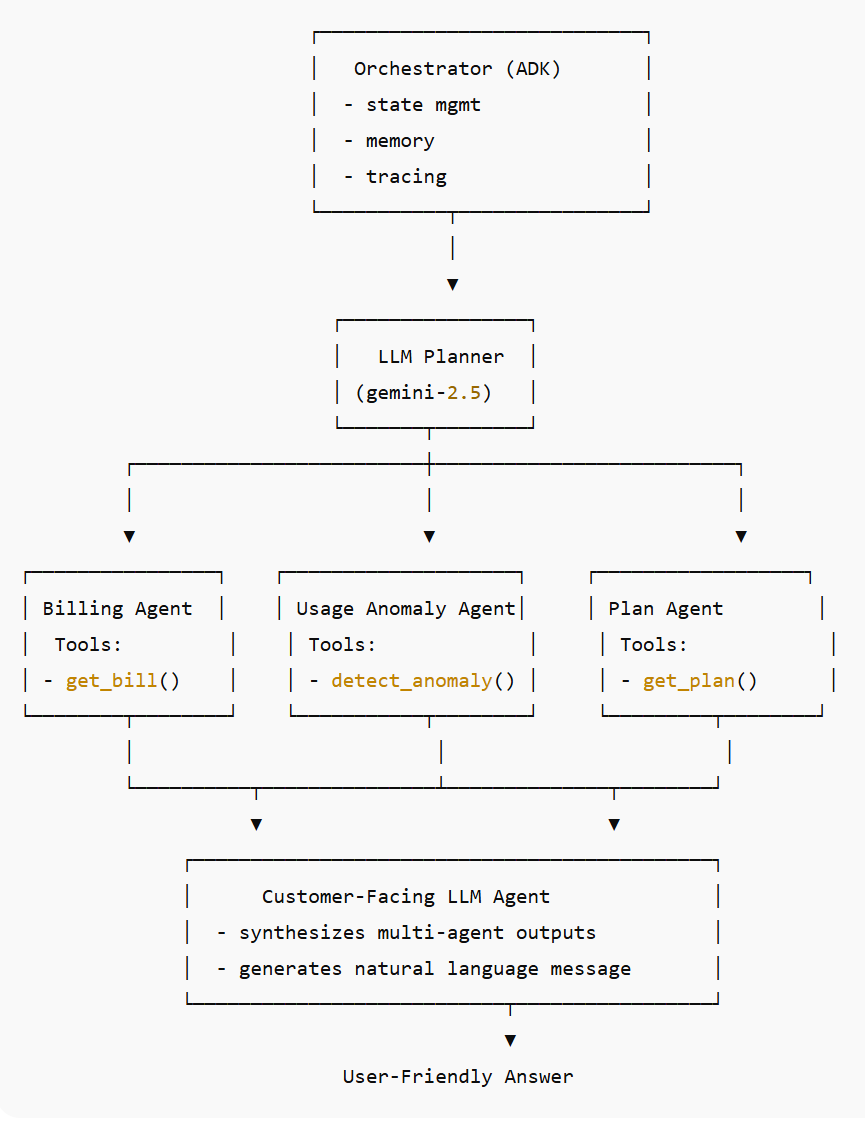

The Agentic AI Billing Anomaly Investigation System transforms billing inquiry resolution from a manual, expert-dependent activity into an automated, accurate, multi-agent intelligent workflow. With seamless orchestration of billing, usage analytics, and plan evaluation — combined with friendly customer communication — telecom operators gain a scalable, reliable, and transparent mechanism for resolving billing disputes instantly.

# The Implementation

---
## 1: Setup

### 1.1: Install dependencies

The Kaggle Notebooks environment includes a pre-installed version of the [google-adk](https://google.github.io/adk-docs/) library for Python and its required dependencies, so you don't need to install additional packages in this notebook.

To install and use ADK in your own Python development environment outside of this course, you can do so by running:

```
pip install google-adk
```

### 1.2: Configure your Gemini API Key

This notebook uses the [Gemini API](https://ai.google.dev/gemini-api/docs), which requires authentication.

**1. Get your API key**

If you don't have one already, create an [API key in Google AI Studio](https://aistudio.google.com/app/api-keys).

**2. Add the key to Kaggle Secrets**

Next, you will need to add your API key to your Kaggle Notebook as a Kaggle User Secret.

1. In the top menu bar of the notebook editor, select `Add-ons` then `Secrets`.
2. Create a new secret with the label `GOOGLE_API_KEY`.
3. Paste your API key into the "Value" field and click "Save".
4. Ensure that the checkbox next to `GOOGLE_API_KEY` is selected so that the secret is attached to the notebook.

**3. Authenticate in the notebook**

Run the cell below to complete authentication.

In [2]:
import os
from kaggle_secrets import UserSecretsClient

try:
    GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
    os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
    print("✅ Gemini API key setup complete.")
except Exception as e:
    print(
        f"🔑 Authentication Error: Please make sure you have added 'GOOGLE_API_KEY' to your Kaggle secrets. Details: {e}"
    )

✅ Gemini API key setup complete.


### 1.3: Import Global components

Now, import the additional components.

| Import | Purpose in Agentic AI Systems
| ------ | ----------------------------- |
| os | Env variables, filesystem, config |
| json | State exchange, A2A messages, datasets |
| time | Timing, retry logic, agent pacing |
| logging |	Observability & debugging |
| typing | Type hints for tools/agents |
| dataclasses | Agent configuration + state containers |
| datetime | Time windows, cycles, TTL, timestamps |
| ThreadPoolExecutor | Parallel agents/tools |


In [3]:
import os
import json
import time
import logging
from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional
from concurrent.futures import ThreadPoolExecutor, as_completed
from datetime import datetime, timedelta

print("Additional global Components imported successfully")

Additional global Components imported successfully


### 1.4: Import ADK components

Now, import the specific components you'll need from the Agent Development Kit and the Generative AI library. This keeps your code organized and ensures we have access to the necessary building blocks.

In [4]:
from google.adk.models.google_llm import Gemini

from google.adk.tools import load_memory, preload_memory
from google.adk.tools import AgentTool, FunctionTool, google_search
from google.adk.tools import google_search, AgentTool, ToolContext

from google.adk.agents import LlmAgent
from google.adk.agents import Agent, SequentialAgent, ParallelAgent, LoopAgent

from google.adk.runners import InMemoryRunner
from google.adk.runners import Runner

from google.genai import types

from google.adk.sessions import InMemorySessionService
from google.adk.sessions import DatabaseSessionService
from google.adk.memory import InMemoryMemoryService

from google.adk.apps.app import App, EventsCompactionConfig

from google.adk.code_executors import BuiltInCodeExecutor

# Model constant (Gemini)
GEMINI_MODEL = "gemini-2.5-flash-lite"

# Logging - TBD
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("billing-agent-system")

print("✅ ADK components imported successfully.")

✅ ADK components imported successfully.


### 1.5: Create Helper functions

#### 1.5.1: Helper functions - Tools

Helper function that prints the generated Python code and results from the code execution tool:

The function:

1. Looks through a structured response.

2. Finds any part that contains output from a Python execution tool.

3. If the result contains "tool_code" → prints it as generated Python code.

4. Otherwise → prints it as a Python execution result.

5. Safely avoids accessing missing attributes using layered checks.

In [5]:
def show_python_code_and_result(response):
    for i in range(len(response)):
        # Check if the response contains a valid function call result from the code executor
        if (
            (response[i].content.parts)
            and (response[i].content.parts[0])
            and (response[i].content.parts[0].function_response)
            and (response[i].content.parts[0].function_response.response)
        ):
            response_code = response[i].content.parts[0].function_response.response
            if "result" in response_code and response_code["result"] != "```":
                if "tool_code" in response_code["result"]:
                    print(
                        "Generated Python Code >> ",
                        response_code["result"].replace("tool_code", ""),
                    )
                else:
                    print("Generated Python Response >> ", response_code["result"])


print("✅ Helper functions defined.")

✅ Helper functions defined.


#### 1.5.2: Helper functions - Sessions

Helper function that manages a complete conversation session, handling session
creation/retrieval, query processing, and response streaming. It supports
both single queries and multiple queries in sequence.

Example:

```
>>> await run_session(runner, "What is the capital of France?", "geography-session")
>>> await run_session(runner, ["Hello!", "What's my name?"], "user-intro-session")
```

In [6]:
# Define helper functions that will be reused throughout the notebook
async def run_session(
    runner_instance: Runner, user_queries: list[str] | str, session_id: str = "default"
):
    """Helper function to run queries in a session and display responses."""
    print(f"\n### Session: {session_id}")

    # Create or retrieve session
    try:
        session = await session_service.create_session(
            app_name=APP_NAME, user_id=USER_ID, session_id=session_id
        )
    except:
        session = await session_service.get_session(
            app_name=APP_NAME, user_id=USER_ID, session_id=session_id
        )

    # Convert single query to list
    if isinstance(user_queries, str):
        user_queries = [user_queries]

    # Process each query
    for query in user_queries:
        print(f"\nUser > {query}")
        query_content = types.Content(role="user", parts=[types.Part(text=query)])

        # Stream agent response
        async for event in runner_instance.run_async(
            user_id=USER_ID, session_id=session.id, new_message=query_content
        ):
            if event.is_final_response() and event.content and event.content.parts:
                text = event.content.parts[0].text
                if text and text != "None":
                    print(f"Model: > {text}")


print("✅ Helper functions defined.")

✅ Helper functions defined.


In [7]:
# Define helper functions that will be reused throughout the notebook (Optional - TBD)
async def run_session(
    runner_instance: Runner,
    user_queries: list[str] | str = None,
    session_name: str = "default",
):
    print(f"\n ### Session: {session_name}")

    app_name = runner_instance.app_name

    # Create or load session
    try:
        session = await session_service.create_session(
            app_name=app_name,
            user_id=USER_ID,
            session_id=session_name
        )
    except:
        session = await session_service.get_session(
            app_name=app_name,
            user_id=USER_ID,
            session_id=session_name
        )

    if user_queries:
        if isinstance(user_queries, str):
            user_queries = [user_queries]

        for query in user_queries:
            print(f"\nUser > {query}")

            query_msg = types.Content(
                role="user",
                parts=[types.Part(text=query)]
            )

            async for event in runner_instance.run_async(
                user_id=USER_ID,
                session_id=session_name,     # ✅ FIXED
                new_message=query_msg
            ):
                if event.content and event.content.parts:
                    text = event.content.parts[0].text
                    if text and text != "None":
                        print(f"{MODEL_NAME} > {text}")
    else:
        print("No queries!")



print("✅ Helper functions defined.")

✅ Helper functions defined.


### 1.6: Configure Retry Options

When working with LLMs, you may encounter transient errors like rate limits or temporary service unavailability. Retry options automatically handle these failures by retrying the request with exponential backoff.

In [8]:
retry_config = types.HttpRetryOptions(
    attempts=5,  # Maximum retry attempts
    exp_base=7,  # Delay multiplier
    initial_delay=1,
    http_status_codes=[429, 500, 503, 504],  # Retry on these HTTP errors
)

## 2: Define Tools (ADK FunctionTool / BaseTool wrappers for telco stubs)

Tools are how ADK agents call external functions safely. We wrap the stubs so that ADK agents can call them.

### 2.1: Billing Lookup Tool

This tool simulates querying a telecom billing system and returning bill details for the provided MSISDN.

In [9]:
# Billing Lookup Tool

def get_bill_for_msisdn(msisdn: str) -> dict:
    """Fetches billing information for a given MSISDN (mobile number).

    This tool simulates querying a telecom billing system and returning
    bill details for the provided MSISDN. It acts as a stub during development
    and testing when the real billing system is unavailable.

    Args:
        msisdn: The mobile number (MSISDN) for which billing details are required.

    Returns:
        Dictionary with status and bill information.
        Success: {
            "status": "success",
            "bill": {
                "msisdn": "9876543210",
                "bill_cycle": "Nov-2025",
                "total_amount": 1420,
                "usage": {
                    "data_gb": 78,
                    "voice_minutes": 230,
                    "roaming_minutes": 40,
                    "extra_charges": 299
                }
            }
        }

        Error: {
            "status": "error",
            "error_message": "Billing details for MSISDN not found"
        }
    """

    # Simulated stub database that mimics a telecom billing system.
    billing_database = {
        "9876543210": {
            "bill_cycle": "Nov-2025",
            "total_amount": 1420,
            "usage": {
                "data_gb": 78,
                "voice_minutes": 230,
                "roaming_minutes": 40,
                "extra_charges": 299,
            },
        },
        "9123456780": {
            "bill_cycle": "Nov-2025",
            "total_amount": 980,
            "usage": {
                "data_gb": 45,
                "voice_minutes": 120,
                "roaming_minutes": 0,
                "extra_charges": 50,
            },
        },
    }

    bill = billing_database.get(msisdn)

    if bill is not None:
        # Merge msisdn back into bill structure
        return {
            "status": "success",
            "bill": {"msisdn": msisdn, **bill},
        }
    else:
        return {
            "status": "error",
            "error_message": f"Billing details for MSISDN '{msisdn}' not found",
        }


print("✅ Bill lookup function based tool created")
print(f"💳 Test1: {get_bill_for_msisdn('9123456780')}")
print(f"💳 Test2: {get_bill_for_msisdn('9123456880')}")


✅ Bill lookup function based tool created
💳 Test1: {'status': 'success', 'bill': {'msisdn': '9123456780', 'bill_cycle': 'Nov-2025', 'total_amount': 980, 'usage': {'data_gb': 45, 'voice_minutes': 120, 'roaming_minutes': 0, 'extra_charges': 50}}}
💳 Test2: {'status': 'error', 'error_message': "Billing details for MSISDN '9123456880' not found"}


### 2.2: Usage Anaytics Tool

This tool simulates telecom usage analytics logic, identifying patterns such as unusually high roaming minutes or unexpected behavior.

In [10]:
# Usage Analytics Tool

def detect_usage_anomaly(usage: dict) -> dict:
    """Analyzes customer telecom usage and detects potential anomalies.

    This tool simulates telecom usage analytics logic, identifying patterns
    such as unusually high roaming minutes or unexpected behavior. It acts as
    a stub for early development when the real analytics engine is unavailable.

    Args:
        usage: A dictionary representing the customer’s usage metrics.
               Example:
               {
                   "data_gb": 78,
                   "voice_minutes": 230,
                   "roaming_minutes": 40,
                   "extra_charges": 299
               }

    Returns:
        Dictionary with anomaly detection status:
        Success (anomaly found):
            {
                "status": "success",
                "anomaly": True,
                "anomaly_details": {
                    "type": "Unexpected roaming charges",
                    "cause": "High roaming usage",
                    "recommendation": "Enable roaming alerts or purchase roaming pack"
                }
            }

        Success (no anomaly):
            {
                "status": "success",
                "anomaly": False
            }

        Error (invalid input):
            {
                "status": "error",
                "error_message": "Missing required field: 'roaming_minutes'"
            }
    """

    # Validate required fields
    required_fields = ["roaming_minutes"]
    for field in required_fields:
        if field not in usage:
            return {
                "status": "error",
                "error_message": f"Missing required field: '{field}'",
            }

    # Simple detection rule: roaming > 30 minutes triggers anomaly
    if usage["roaming_minutes"] > 30:
        return {
            "status": "success",
            "anomaly": True,
            "anomaly_details": {
                "type": "Unexpected roaming charges",
                "cause": "High roaming usage",
                "recommendation": "Enable roaming alerts or purchase roaming pack",
            },
        }

    # Normal usage → no anomaly detected
    return {
        "status": "success",
        "anomaly": False
    }

print("✅ usage anamoly lookup function based tool created")
print(f"💳 Test1: {detect_usage_anomaly('40')}")
print(f"💳 Test2: {detect_usage_anomaly('10')}")

✅ usage anamoly lookup function based tool created
💳 Test1: {'status': 'error', 'error_message': "Missing required field: 'roaming_minutes'"}
💳 Test2: {'status': 'error', 'error_message': "Missing required field: 'roaming_minutes'"}


### 2.3: Customer Plan Lookup Tool

This tool simulates retrieving customer plan information from a telecom CRM system

In [11]:
# Customer Plan Tool

def get_customer_plan(msisdn: str) -> dict:
    """Fetches the subscribed plan details for a given MSISDN (mobile number).

    This tool simulates retrieving customer plan information from a telecom CRM
    system. It is useful during development and testing when the real CRM API
    is not yet integrated.

    Args:
        msisdn: The mobile number (MSISDN) whose plan details need to be fetched.

    Returns:
        Dictionary with status and plan information.

        Success:
            {
                "status": "success",
                "plan_details": {
                    "msisdn": "9876543210",
                    "plan": "Premium Unlimited+",
                    "data_limit": "100GB",
                    "roaming_pack": "None"
                }
            }

        Error:
            {
                "status": "error",
                "error_message": "Plan details for MSISDN not found"
            }
    """

    # Simulated CRM plan database
    crm_database = {
        "9876543210": {
            "plan": "Premium Unlimited+",
            "data_limit": "100GB",
            "roaming_pack": "None"
        },
        "9123456780": {
            "plan": "Family Saver 50GB",
            "data_limit": "50GB",
            "roaming_pack": "Asia Pack"
        }
    }

    plan = crm_database.get(msisdn)

    if plan is not None:
        return {
            "status": "success",
            "plan_details": {
                "msisdn": msisdn,
                **plan
            }
        }
    else:
        return {
            "status": "error",
            "error_message": f"Plan details for MSISDN '{msisdn}' not found",
        }


print("✅ Customer Plan lookup function based tool created")
print(f"💳 Test1: {get_customer_plan('9123456780')}")
print(f"💳 Test2: {get_customer_plan('9123456880')}")
 


✅ Customer Plan lookup function based tool created
💳 Test1: {'status': 'success', 'plan_details': {'msisdn': '9123456780', 'plan': 'Family Saver 50GB', 'data_limit': '50GB', 'roaming_pack': 'Asia Pack'}}
💳 Test2: {'status': 'error', 'error_message': "Plan details for MSISDN '9123456880' not found"}


## 3: Agent Definitions

### 3.1: Billing Agent

A specialised LLM agent that retrieves telecom billing information by strictly invoking the get_bill_for_msisdn tool, validates the response, extracts bill fields without modification, and returns the result as structured JSON only.

In [12]:
# Billing Fetch Agent

billing_agent = LlmAgent(
    name="billing_agent",
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    
    instruction="""You are a telecom billing retrieval assistant. 
You must strictly follow the steps below and use the available tools exactly as instructed.

For any request to retrieve customer billing information:

1. Fetch Billing Details  
   • You must call the get_bill_for_msisdn tool.  
   • Input: The MSISDN provided by the user.  
   • Do NOT fabricate or guess billing details — always use the tool.

2. Validate Tool Response  
   • After calling get_bill_for_msisdn, check the "status" field.  
   • If status == "error", immediately stop and return a structured JSON object explaining the issue.  
   • If status == "success", continue.

3. Extract Usage & Bill Context
   • From the tool response, extract all relevant bill fields such as:  
        - bill_cycle  
        - total_amount  
        - usage (data, voice, roaming, extra charges)  
   • You must NOT modify, calculate, reinterpret, or infer values.  
     Only return what the tool provides.

4. Output Format (CRITICAL)  
   • You must return only structured JSON.  
   • Your JSON must contain the key "bill" as the top-level output.  
   • No conversational text, no sentences, no explanations — only JSON.

""",

    tools=[get_bill_for_msisdn],
    output_key="bill"
)

print("✅ Billing agent created")
#print("🎯 New capability: Delegates calculations to specialist agent")
print("🔧 Tool types used:")
#print("  • Function Tools (fees, rates)")
#print("  • Agent Tool (calculation specialist)")

✅ Billing agent created
🔧 Tool types used:


### 3.2: Usage Anomaly Agent

A parallel-analysis agent that detects abnormal telecom usage patterns by invoking the detect_usage_anomaly tool, validates the tool’s report, and returns a strictly structured JSON anomaly report without making any assumptions or inferences.

In [13]:
# Usage Anomaly Agent (Parallel Agent)

usage_agent = LlmAgent(
    name="usage_anomaly_agent",
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    instruction="""
You are an intelligent telecom usage-analysis assistant.
You must strictly follow the steps below and use the available tools.

Your purpose:
Analyze customer usage data and identify any anomalies using the provided usage analytics tool.

------------------------
STEP-BY-STEP EXECUTION
------------------------

1. **Fetch Usage Anomaly Insight**
   - Use the `detect_usage_anomaly` tool.
   - Pass the complete customer usage object exactly as received.
   - This tool checks for abnormal or unexpected usage patterns (e.g., high roaming minutes).

2. **Validate Tool Response**
   - After receiving the tool output, check that the response contains `"anomaly"` and `"type"` fields.
   - If the tool returns malformed data or is missing required fields, stop and return a JSON error:
     `{ "error": "Invalid anomaly report received from tool" }`

3. **Do Not Infer or Guess**
   - You must not generate your own anomaly detection logic.
   - You must rely ONLY on the tool’s output.
   - Do not invent or assume usage values.

4. **Return Final Output**
   - Your final answer must be strictly valid JSON.
   - Return only the anomaly report in the following structure:
     {
        "anomaly_report": {
            "anomaly": <true/false>,
            "type": "<text>",
            "cause": "<text>",
            "recommendation": "<text>"
        }
     }

""",

    tools=[detect_usage_anomaly],
    output_key="anomaly_report"
)


print("✅ usage anomaly agent created")
#print("🎯 New capability: Delegates calculations to specialist agent")
print("🔧 Tool types used:")
#print("  • Function Tools (fees, rates)")
#print("  • Agent Tool (calculation specialist)")

✅ usage anomaly agent created
🔧 Tool types used:


### 3.3:Plan Retrieval Agent

A dedicated agent that fetches customer plan details using the get_customer_plan tool, validates the response, and returns a strict JSON object containing only the customer's plan information, without adding any extra text or inference.

In [14]:
# Plan Retrieval Agent

plan_agent = LlmAgent(
    name="plan_agent",
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),

    instruction="""
You are an intelligent telecom customer-plan assistant. You must strictly follow the
steps below and use the provided tools correctly.

Your goal: Fetch and return the customer's plan information.

----------------------
### 🚀 REQUIRED STEPS
----------------------

1. **Fetch Plan Details**
   - Use the `get_customer_plan` tool.
   - Input required: `msisdn`.
   - The tool returns plan attributes (e.g., plan name, data limits, roaming packs).

2. **Validate Tool Output**
   - After calling the tool, ensure the output is valid JSON.
   - If the tool returns invalid, missing, or incomplete data:
        - Stop immediately.
        - Return a clear JSON error: 
          `{ "error": "Unable to retrieve customer plan information" }`

3. **Return Final Output**
   - You must return ONLY a strict JSON object with the key:
        - `"plan"`
   - Do NOT add any explanation, natural language, or text outside JSON.

----------------------
### 📌 FINAL RESPONSE FORMAT
----------------------
{
   "plan": { ... }
}

    """,

    tools=[get_customer_plan],
    output_key="plan"
)


print("✅ Plan Retreival agent created")
#print("🎯 New capability: Delegates calculations to specialist agent")
print("🔧 Tool types used:")
#print("  • Function Tools (fees, rates)")
#print("  • Agent Tool (calculation specialist)")

✅ Plan Retreival agent created
🔧 Tool types used:


### 3.4: Customer Facing Agent

A final synthesis agent that interprets billing, anomaly, and plan outputs from previous agents and produces a clear, empathetic, customer-friendly explanation in strict JSON format without invoking any tools.

In [15]:
# Final Reasoning + Customer Response Agent
# This agent performs:
# Sequential reasoning
# Synthesis across previous agents
# Human-friendly message generation

customer_agent = LlmAgent(
    name="customer_facing_agent",
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    instruction="""
You are the final customer communication agent. You synthesize the outputs of 
previous agents and generate a clear, customer-friendly explanation.

You will receive four inputs:
- bill             → Billing details from the billing agent
- anomaly_report   → Usage anomaly analysis
- plan             → Customer's subscribed plan details
- memory           → Relevant historical customer profile or past interactions

------------------------------
### 🚀 REQUIRED BEHAVIOR
------------------------------

1. **Interpret Inputs**
   - Read `bill`, `anomaly_report`, and `plan`.
   - Understand the customer's billing context, usage behaviour, and entitlements.

2. **Determine Whether an Anomaly Exists**
   - If `anomaly_report.anomaly == true`, clearly explain:
       * What anomaly was detected
       * Likely cause
       * Recommendation (e.g., roaming packs, alerts)
   - If no anomaly is detected, reassure the customer politely.

3. **Generate a Human-Friendly Summary**
   - Use simple, clear language.
   - Avoid technical jargon.
   - Tone must be polite, empathetic, and helpful.

4. **Provide Actionable Recommendations**
   - Suggestions may include:
       * Reviewing plan details
       * Enabling alerts
       * Considering a pack upgrade
       * Contacting support if needed

5. **If `memory` contains past anomalies, customer profile, complaints, or plan changes** 
   - incorporate that context to generate a more personalized message.

6. **STRICT OUTPUT FORMAT**
   - You must output ONLY a JSON object with the following field:
   
{
  "final_message": "<human-friendly response text>"
}

   - No commentary, no extra fields, no markdown.

------------------------------
### 📌 IMPORTANT RULES
------------------------------
- Do NOT hallucinate any billing amounts or data values not present in inputs.
- Do NOT output tool calls — this agent does not use tools.
- Keep message concise but helpful.

    """,

    tools=[],
    output_key="final_message"
)


print("✅ Customer facing agent created")
#print("🎯 New capability: Delegates calculations to specialist agent")
print("🔧 Tool types used:")
#print("  • Function Tools (fees, rates)")
#print("  • Agent Tool (calculation specialist)")

✅ Customer facing agent created
🔧 Tool types used:


### 3.5: Memory Agent

The Memory Agent is a lightweight LLM-powered utility responsible for retrieving historical customer context, such as past usage anomalies, prior bills, preferences, or interaction history. It acts as a dedicated interface to the system’s long-term memory through the load_memory tool. When invoked, the agent fetches only the relevant memory required by downstream agents—ensuring decisions, reasoning, and customer communications are fully context-aware. This agent does not perform analysis itself; instead, it enables other agents to operate with richer and more personalized information.

In [16]:
# Memory Agent - An LlMAgent that exposes the memory tool

load_memory_agent = LlmAgent(
    name="LoadMemoryToolAgent",
    model="gemini-2.5-flash-lite",
    instruction="Use the memory loader tool when needed.",
    tools=[load_memory],
)

print("✅ Memory agent created")
#print("🎯 New capability: Delegates calculations to specialist agent")
print("🔧 Tool types used:")
#print("  • Function Tools (fees, rates)")
#print("  • Agent Tool (calculation specialist)")

✅ Memory agent created
🔧 Tool types used:


### 3.6: Auto Memory Agent

The Auto Memory Agent is an enhanced memory-aware LLM agent designed to both preload relevant historical context and automatically save new insights after every interaction. Using the preload_memory tool, it proactively retrieves prior sessions, customer behaviours, and past anomaly findings so downstream agents can reason with complete context.

In addition, its callback function (auto_save_to_memory) ensures that each agent turn is persisted back into long-term memory—creating a continuously self-improving system. This agent acts as the backbone of contextual intelligence, ensuring that the overall agentic workflow becomes progressively more personalised, accurate, and conversationally consistent over time.

In [17]:
# Auto Memory Agent - An LlMAgent with callback and PreLoad Memory Tool

async def auto_save_to_memory(callback_context):
    """Automatically save session to memory after each agent turn."""
    await callback_context._invocation_context.memory_service.add_session_to_memory(
        callback_context._invocation_context.session
    )

print("✅ Callback created.")

auto_memory_agent = LlmAgent(
    name="AutoMemoryToolAgent",
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    instruction="Use the memory Preloader tool when needed.",
    tools=[preload_memory],
    after_agent_callback=auto_save_to_memory,  # Saves after each turn!
)

print("✅ Agent created with automatic memory saving!")
#print("🎯 New capability: Delegates calculations to specialist agent")
print("🔧 Tool types used:")
#print("  • Function Tools (fees, rates)")
#print("  • Agent Tool (calculation specialist)")

✅ Callback created.
✅ Agent created with automatic memory saving!
🔧 Tool types used:


## 4: Orchestrator: Parallel + Sequential Flow

👉 We then orchestrate the agents by placing a parallel agent inside a sequential agent.

This structure guarantees that the Billing Fetch Agent runs first, and once billing data is retrieved, the system triggers the Usage Anomaly Agent and Plan Retrieval Agent in parallel. After both parallel tasks finish, the Customer-Facing Aggregator Agent consolidates all outputs into one unified response.

**Execution Flow:** 

 **Step 1:** Billing fetch 
 
 **Step 2:** Parallel agents → Usage + Plan 
 
 **Step 3:** Sequential execution → Customer-facing summarisation

In [18]:
# The ParallelAgent runs all its sub-agents simultaneously.
parallel_agents_team = ParallelAgent(
    name="ParallelUsageandPlanTeam",
    sub_agents=[usage_agent, plan_agent],
)

# This SequentialAgent defines the high-level workflow: run the parallel team first, then run the aggregator.
workflow_agent = SequentialAgent(
    name="BillingAnomalySystem",
    sub_agents=[auto_memory_agent,billing_agent, parallel_agents_team, customer_agent], # Agent now has access to Memory and can search it whenever it decides to!
 )

print("✅ Parallel and Sequential Agents created.")
print("✅ Agent with Preload_memory tool created.")


✅ Parallel and Sequential Agents created.
✅ Agent with Preload_memory tool created.


## 5: Implementing Sessions and Memory

### 5.1 Initialize Memory

ADK provides multiple `MemoryService` implementations through the `BaseMemoryService` interface:

- **`InMemoryMemoryService`** - Built-in service for prototyping and testing (keyword matching, no persistence)
- **`VertexAiMemoryBankService`** - Managed cloud service with LLM-powered consolidation and semantic search
- **Custom implementations** - You can build your own using databases, though managed services are recommended

For this notebook, we'll use `InMemoryMemoryService` to implement the core mechanics. The same methods work identically with production-ready services like Vertex AI Memory Bank.

In [19]:
# memory service 

memory_service = (
    InMemoryMemoryService()
)  # ADK's built-in Memory Service for development and testing

print("✅ Memory Service created.")

✅ Memory Service created.


### 5.2 Add Memory to Agent

#### **Create Runner**

Now provide both Session and Memory services to the `Runner`.

**Key configuration:**

The `Runner` requires both services to enable memory functionality:
- **`session_service`** → Manages conversation threads and events
- **`memory_service`** → Provides long-term knowledge storage

Both services work together: Sessions capture conversations, Memory stores knowledge for retrieval across sessions.

In [20]:
APP_NAME = "default"  # Application
USER_ID = "default"  # User
SESSION = "default"  # Session
MODEL_NAME = "gemini-2.5-flash-lite"     # or your actual model

# Create Session Service
session_service = InMemorySessionService()  # Handles conversations

# Create runner with BOTH services
runner = Runner(
    agent=workflow_agent,
    app_name=APP_NAME,
    session_service=session_service,
    memory_service=memory_service,  # Memory service is now available!
)

print("✅ Agent and Runner created with memory support!")

✅ Agent and Runner created with memory support!


###  5.3: Ingest Session Data into Memory 💾

#### ‼️ Important

**💡 Configuration vs. Usage:** Adding `memory_service` to the `Runner` makes memory *available* to your agent, but doesn't automatically use it. You must explicitly:
1. **Ingest data** using `add_session_to_memory()` 
2. **Enable retrieval** by giving your agent memory tools (`load_memory` or `preload_memory`)

Let's implement these steps next!

#### MemoryService Implementation Options

**This notebook: `InMemoryMemoryService`**
- Stores raw conversation events without consolidation
- Keyword-based search (simple word matching)
- In-memory storage (resets on restart)
- Ideal for learning and local development

**Production: `VertexAiMemoryBankService`**
- LLM-powered extraction of key facts
- Semantic search (meaning-based retrieval)
- Persistent cloud storage
- Integrates external knowledge sources

**💡 API Consistency:** Both implementations use identical methods (`add_session_to_memory()`, `search_memory()`). The workflow you learn here applies to all memory services!

**Why should you transfer Session data to Memory?**

Now that memory is initialized, you need to populate it with knowledge. When you initialize a MemoryService, it starts completely empty. All your conversations are stored in Sessions, which contain raw events including every message, tool call, and metadata. To make this information available for long-term recall, you explicitly transfer it to memory using `add_session_to_memory()`.

Here's where managed memory services like Vertex AI Memory Bank shine. **During transfer, they perform intelligent consolidation - extracting key facts while discarding conversational noise.** The `InMemoryMemoryService` we're using stores everything without consolidation, which is sufficient for learning the mechanics.

Before we can transfer anything, we need data. Let's have a conversation with our agent to populate the session. This conversation will be stored in the SessionService .

### 5.4: Try it Out

The orchestrator is invoked using run_session(), which runs the full agentic workflow while maintaining a **persistent session ID**.
This ensures that the system can **store and recall context across turns** using memory.

In this example:

* The runner executes the complete agent pipeline.
* The input query is processed through the billing, usage, and plan agents.
* "conversation_01" acts as the **persistent conversation identifier**, allowing memory-enabled agents to recall past interactions.

In [21]:
# Instantiate Orchestrator (with persisitent sessions and Memory)

await run_session(
    runner,
    "My mobile number is 9876543210,What are my usage details?",
    "conversation_01",# Session ID
)


 ### Session: conversation_01

User > My mobile number is 9876543210,What are my usage details?
gemini-2.5-flash-lite > I am sorry, but I cannot access your personal usage details, including your mobile number and its associated usage information. My purpose is to provide information and complete tasks based on the data I have been trained on, and I do not have access to private user accounts or sensitive personal data.

To get your usage details, please contact your mobile service provider directly. They will be able to provide you with accurate and up-to-date information about your mobile usage.


gemini-2.5-flash-lite > {"bill": {"bill_cycle": "Nov-2025", "total_amount": 1420, "usage": {"data_gb": 78, "voice_minutes": 230, "roaming_minutes": 40, "extra_charges": 299}}}



gemini-2.5-flash-lite > ```json
{
  "final_message": "Hello! I've reviewed your latest bill for November 2025. Your total amount due is $1420. This includes 78GB of data, 230 voice minutes, and 40 roaming minutes, with $299 in extra charges.\n\nWe've detected an anomaly in your usage: unusually high roaming charges. This is likely due to significant roaming usage during your last billing cycle. As you are on the 'Premium Unlimited+' plan with a 100GB data limit and no active roaming pack, we recommend enabling roaming alerts or considering a roaming pack for future travel to avoid unexpected costs. \n\nIf you have any questions or need further assistance, please don't hesitate to reach out!"
}
```


**Let's verify the conversation was captured in the session. You should see the session events containing both the user's prompt and the model's response.**

In [22]:
session = await session_service.get_session(
    app_name=APP_NAME, user_id=USER_ID, session_id="conversation_01"
)

print("📝 Session contains:")
for event in session.events:

    role = event.content.role if event.content else "(no-role)"

    # Handle missing content, missing parts, or non-text parts safely
    if event.content and event.content.parts:
        part = event.content.parts[0]

        # 1. Text part
        if hasattr(part, "text") and part.text:
            preview = part.text[:60]

        # 2. Function call part
        elif hasattr(part, "function_call") and part.function_call:
            preview = f"[function_call] {part.function_call.name}"

        # 3. Unknown structure
        else:
            preview = "(non-text content)"
    else:
        preview = "(empty)"

    print(f"  {role}: {preview}...")


📝 Session contains:
  user: My mobile number is 9876543210,What are my usage details?...
  model: I am sorry, but I cannot access your personal usage details,...
  model: [function_call] get_bill_for_msisdn...
  user: (non-text content)...
  model: {"bill": {"bill_cycle": "Nov-2025", "total_amount": 1420, "u...
  model: [function_call] detect_usage_anomaly...
  user: (non-text content)...
  model: [function_call] get_customer_plan...
  user: (non-text content)...
  model: (empty)...
  model: (empty)...
  model: ```json
{
  "final_message": "Hello! I've reviewed your late...


**The session containing our conversation is now added to memory. Now let's check if the agent is able to retrieve the information from memory by running the full agentic workflow again, under a brand-new session ID**

In [23]:
# Instantiate Orchestrator with a new session

await run_session(
    runner,
    "What is my mobile number and Why is my bill so high?",
    "conversation_02",# Session ID
)


 ### Session: conversation_02

User > What is my mobile number and Why is my bill so high?
gemini-2.5-flash-lite > I am sorry, but I cannot access your personal information, including your mobile number, nor can I access your billing details. My purpose is to provide information and complete tasks based on the data I have been trained on, and I do not have access to private user accounts or sensitive personal data.

To find out your mobile number and understand why your bill is high, please contact your mobile service provider directly. They will be able to assist you with this information.
gemini-2.5-flash-lite > I need your mobile number (MSISDN) to retrieve your billing information. Please provide it so I can look up your bill details.
gemini-2.5-flash-lite > I cannot access your personal information, including your mobile number, nor can I access your billing details. My purpose is to provide information and complete tasks based on the data I have been trained on, and I do not hav

### 5.5: Search Memory 🤖 

Beyond agent tools, you can also search memories directly in your code. This is useful for:
- Debugging memory contents
- Building analytics dashboards  
- Creating custom memory management UIs

The `search_memory()` method takes a text query and returns a `SearchMemoryResponse` with matching memories.


In [24]:
# Search for Mobile Number
search_response = await memory_service.search_memory(
    app_name=APP_NAME, user_id=USER_ID, query="What is the user's mobile number?"
)

print("🔍 Search Results:")
print(f"  Found {len(search_response.memories)} relevant memories")
print()

for memory in search_response.memories:
    if memory.content and memory.content.parts:
        text = memory.content.parts[0].text[:80]
        print(f"  [{memory.author}]: {text}...")


🔍 Search Results:
  Found 4 relevant memories

  [user]: My mobile number is 9876543210,What are my usage details?...
  [AutoMemoryToolAgent]: I am sorry, but I cannot access your personal usage details, including your mobi...
  [user]: What is my mobile number and Why is my bill so high?...
  [AutoMemoryToolAgent]: I am sorry, but I cannot access your personal information, including your mobile...


## 7:  Agent Observability 🔎

#### What is Agent Observability?

**🚨 The challenge:** Unlike traditional software that fails predictably, AI agents can fail mysteriously. Example:

```
User: "Find quantum computing papers"
Agent: "I cannot help with that request."
You: 😭 WHY?? Is it the prompt? Missing tools? API error?
```

**💡 The Solution:** Agent observability gives you complete visibility into your agent's decision-making process. You'll see exactly what prompts are sent to the LLM, which tools are available, how the model responds, and where failures occur.

```
DEBUG Log: LLM Request shows "Functions: []" (no tools!)
You: 🎯 Aha! Missing google_search tool - easy fix!
```

#### Foundational pillars of Agent Observability

1. **Logs:** A log is a record of a single event, telling you **what** happened at a specific moment.
2. **Traces:** A trace connects the logs into a single story, showing you **why** a final result occurred by revealing the entire sequence of steps.
3. **Metrics:** Metrics are the summary numbers (like averages and error rates) that tell you **how** well the agent is performing overall.

We need a way to capture observability data or in other words, **add logs to our code**. 

👉 In traditional software development, this is done by adding log statements in Python functions - **and agents are no different!** We need to add log statements to our agent and a common approach is to add log statements to **Plugins**.

#### How to add logs for production observability?

A Plugin is a custom code module that runs automatically at various stages of your agent's lifecycle. Plugins are composed of "**Callbacks**" which provide the hooks to interrupt an agent's flow. Think of it like this:

- **Your agent workflow**: User message → Agent thinks → Calls tools → Returns response
- **Plugin hooks into this**: Before agent starts → After tool runs → When LLM responds → etc.
- **Plugin contains your custom code**: Logging, monitoring, security checks, caching, etc.

![image.png](https://storage.googleapis.com/github-repo/kaggle-5days-ai/day4/plugins-callbacks.png)

#### Callbacks

Callbacks are the **atomic components inside a Plugin** - these are just Python functions that run at specific points in an agent's lifecycle! **Callbacks are grouped together to create a Plugin.**

There are different kinds of callbacks such as:
* **before/after_agent_callbacks** - runs before/after an agent is invoked
* **before/after_tool_callbacks** - runs before/after a tool is called
* **before/after_model_callbacks** - similarly, runs before/after the LLM model is called
* **on_model_error_callback** - which runs when a model error is encountered

![image.png](https://storage.googleapis.com/github-repo/kaggle-5days-ai/day4/types_of_callbacks.png)



###  7.1: Set up logging and cleanup old files ✍️

Let's configure logging for our debugging session. The following cell makes sure we also capture other log levels, like DEBUG.

In [25]:
import logging
import os

# Clean up any previous logs
for log_file in ["logger.log", "web.log", "tunnel.log"]:
    if os.path.exists(log_file):
        os.remove(log_file)
        print(f"🧹 Cleaned up {log_file}")

# Configure logging with DEBUG log level.
logging.basicConfig(
    filename="logger.log",
    level=logging.DEBUG,
    format="%(filename)s:%(lineno)s %(levelname)s:%(message)s",
)

print("✅ Logging configured")

✅ Logging configured


### 7.2: ADK's built-in `LoggingPlugin`

But you don't have to define all the callbacks and plugins to capture *standard* Observability data in ADK. Instead, ADK provides a built-in **LoggingPlugin** that automatically captures all agent activity:

- 🚀 User messages and agent responses
- ⏱️ Timing data for performance analysis
- 🧠 LLM requests and responses for debugging
- 🔧 Tool calls and results
- ✅ Complete execution traces

### 7.3: Add LoggingPlugin to Runner

The following code creates the `InMemoryRunner`. This is used to programmatically invoke the agent.

**To use `LoggingPlugin` in the above research agent,**
1) Import the plugin
2) Add it when initializing the `InMemoryRunner`.


In [26]:
from google.adk.runners import InMemoryRunner
from google.adk.plugins.logging_plugin import (
    LoggingPlugin,
)  # <---- 1. Import the Plugin
from google.genai import types
import asyncio

runner = InMemoryRunner(
    agent=workflow_agent,
    plugins=[
        LoggingPlugin()
    ],  # <---- 2. Add the plugin. Handles standard Observability logging across ALL agents
)

print("✅ Runner configured")

✅ Runner configured


### 7.4: 🔎 Running the Orchestrator with Debug Logging Enabled 

Let's now run the agent using `run_debug` function.The following code executes the agentic billing investigation workflow using the LoggingPlugin.
This plugin captures detailed, step-by-step logs of every agent action—including planning, tool calls, intermediate outputs, and final reasoning—making it ideal for debugging, audits, or demonstrations.

**✅ What this does:**
* Initializes the orchestrator run with full verbosity.
* Shows every agent’s reasoning chain.
* Displays all tool invocations and responses.
* Prints the final synthesized result from the customer-facing agent.
* This mode is extremely useful during development or troubleshooting to understand how agents collaborate internally.


In [27]:
print("🚀 Running agent with LoggingPlugin...")
print("📊 Watch the comprehensive logging output below:\n")

response = await runner.run_debug("Why is the bill high for MSISDN 9876543210 ")

🚀 Running agent with LoggingPlugin...
📊 Watch the comprehensive logging output below:


 ### Created new session: debug_session_id

User > Why is the bill high for MSISDN 9876543210 
[logging_plugin] 🚀 USER MESSAGE RECEIVED
[logging_plugin]    Invocation ID: e-3f34ea7d-c9be-4d9e-b4dc-e85614d749d4
[logging_plugin]    Session ID: debug_session_id
[logging_plugin]    User ID: debug_user_id
[logging_plugin]    App Name: InMemoryRunner
[logging_plugin]    Root Agent: BillingAnomalySystem
[logging_plugin]    User Content: text: 'Why is the bill high for MSISDN 9876543210'
[logging_plugin] 🏃 INVOCATION STARTING
[logging_plugin]    Invocation ID: e-3f34ea7d-c9be-4d9e-b4dc-e85614d749d4
[logging_plugin]    Starting Agent: BillingAnomalySystem
[logging_plugin] 🤖 AGENT STARTING
[logging_plugin]    Agent Name: BillingAnomalySystem
[logging_plugin]    Invocation ID: e-3f34ea7d-c9be-4d9e-b4dc-e85614d749d4
[logging_plugin] 🤖 AGENT STARTING
[logging_plugin]    Agent Name: AutoMemoryToolAgent
[logging_p

[logging_plugin] 🧠 LLM RESPONSE
[logging_plugin]    Agent: billing_agent
[logging_plugin]    Content: function_call: get_bill_for_msisdn
[logging_plugin]    Token Usage - Input: 842, Output: 32
[logging_plugin] 📢 EVENT YIELDED
[logging_plugin]    Event ID: dfa19ea8-3004-4aaf-a006-890cc3a3a356
[logging_plugin]    Author: billing_agent
[logging_plugin]    Content: function_call: get_bill_for_msisdn
[logging_plugin]    Final Response: False
[logging_plugin]    Function Calls: ['get_bill_for_msisdn']
[logging_plugin] 🔧 TOOL STARTING
[logging_plugin]    Tool Name: get_bill_for_msisdn
[logging_plugin]    Agent: billing_agent
[logging_plugin]    Function Call ID: adk-057a5234-8501-4516-95de-306f923ef0e8
[logging_plugin]    Arguments: {'msisdn': '9876543210'}
[logging_plugin] 🔧 TOOL COMPLETED
[logging_plugin]    Tool Name: get_bill_for_msisdn
[logging_plugin]    Agent: billing_agent
[logging_plugin]    Function Call ID: adk-057a5234-8501-4516-95de-306f923ef0e8
[logging_plugin]    Result: {'sta

[logging_plugin] 🧠 LLM RESPONSE
[logging_plugin]    Agent: plan_agent
[logging_plugin]    Content: function_call: get_customer_plan
[logging_plugin]    Token Usage - Input: 989, Output: 28
[logging_plugin] 📢 EVENT YIELDED
[logging_plugin]    Event ID: 5a4ffd02-05e8-49b1-8e72-639716c89a6e
[logging_plugin]    Author: plan_agent
[logging_plugin]    Content: function_call: get_customer_plan
[logging_plugin]    Final Response: False
[logging_plugin]    Function Calls: ['get_customer_plan']
[logging_plugin] 🔧 TOOL STARTING
[logging_plugin]    Tool Name: get_customer_plan
[logging_plugin]    Agent: plan_agent
[logging_plugin]    Function Call ID: adk-961940c8-ec1d-4a57-90f3-935949c572ec
[logging_plugin]    Arguments: {'msisdn': '9876543210'}
[logging_plugin] 🔧 TOOL COMPLETED
[logging_plugin]    Tool Name: get_customer_plan
[logging_plugin]    Agent: plan_agent
[logging_plugin]    Function Call ID: adk-961940c8-ec1d-4a57-90f3-935949c572ec
[logging_plugin]    Result: {'status': 'success', 'plan

![Evaluate](https://storage.googleapis.com/github-repo/kaggle-5days-ai/day4/evaluate_agent.png)


### 8.1: Create evaluation configuration

This file lets us define the pass/fail thresholds. Create `test_config.json` in the root directory.

**Evaluation Configuration Generator**

This code snippet creates a **JSON-based evaluation configuration** used to assess the quality and correctness of an AI agent’s behavior—specifically its tool usage accuracy and final response quality.

**🔍 What the Code Does**

**1. Defines evaluation criteria** inside a Python dictionary:
    * **tool_trajectory_avg_score:** Sets a strict requirement for tool usage correctness.A value of 1.0 means every tool invocation must match the expected trajectory exactly.
    * **response_match_score:** Specifies the minimum text similarity threshold (80%) needed between the agent's final response and the expected answer.
**2. Writes the criteria into a JSON file** (test_config.json) in the evaluation folder (home_automation_agent/).
This file is later used by the evaluation engine or CI pipeline.
**3. Prints human-friendly status messages,** explaining:
   * The meaning of each evaluation metric.
   * The types of agent failures the evaluation system is designed to detect.

**📊 Summary of What This Evaluation Catches**

* **Incorrect or missing tool calls**
(e.g., wrong arguments, wrong device/location, incorrect sequence)
* **Poor-quality user responses**
(unclear, low-quality, or inaccurate final messages)
* **Deviation from expected behavior patterns**
(planning issues, tool misuse, reasoning failures)

In [ ]:
from google.adk.agents import LlmAgent
from google.adk.models.google_llm import Gemini
from google.genai import types



from google.genai import types
from root_agent.workflow_agent import workflow_agent  # your existing agent

# -----------------------------------------------------
# Retry logic (optional – only if your existing agent uses a Gemini model)
# -----------------------------------------------------

retry_config = types.HttpRetryOptions(attempts=5, exp_base=7, initial_delay=1)

# If your existing agent has a model property, attach retry settings
# (Safe to ignore if your agent doesn't use a Gemini model directly)

try:
    workflow_agent.model.retry_options = retry_config
except AttributeError:
    pass  # your workflow_agent may not expose .model or retry options

# -----------------------------------------------------
# ADK requires the exported agent to be named root_agent
# -----------------------------------------------------

root_agent = workflow_agent

print("existing workflow_agent is assigned to root_agent")

In [29]:
import os
import json

# Ensure folder exists
os.makedirs("workflow_agent", exist_ok=True)

# Create an empty __init__.py so Python treats it as a package
with open("workflow_agent/__init__.py", "w") as f:
    f.write("# root_agent package initializer")

print("📦 workflow_agent package initialized!")

# Create evaluation configuration with basic criteria
eval_config = {
    "criteria": {
        "tool_trajectory_avg_score": 1.0,  # Perfect tool usage required
        "response_match_score": 0.8,  # 80% text similarity threshold
    }
}

with open("workflow_agent/test_config.json", "w") as f:
    json.dump(eval_config, f, indent=2)

print("✅ Evaluation configuration created!")
print("\n📊 Evaluation Criteria:")
print("• tool_trajectory_avg_score: 1.0 - Requires exact tool usage match")
print("• response_match_score: 0.8 - Requires 80% text similarity")
print("\n🎯 What this evaluation will catch:")
print("✅ Incorrect tool usage (wrong device, location, or status)")
print("✅ Poor response quality and communication")
print("✅ Deviations from expected behavior patterns")

📦 workflow_agent package initialized!
✅ Evaluation configuration created!

📊 Evaluation Criteria:
• tool_trajectory_avg_score: 1.0 - Requires exact tool usage match
• response_match_score: 0.8 - Requires 80% text similarity

🎯 What this evaluation will catch:
✅ Incorrect tool usage (wrong device, location, or status)
✅ Poor response quality and communication
✅ Deviations from expected behavior patterns


### 8.2: Create test cases

This file (integration.evalset.json) will contain multiple test cases (sessions). These test cases are designed to reveal issues in tool usage, LLM reasoning, agent collaboration, and final customer communication.

✅ What This Evaluation Suite Tests

**1. Tool Usage Problems**
* Broken argument structure
* Missing dependency references
* Incorrect sequence logic

**2. Multi-Agent Collaboration Quality**
* Planner → Investigator → Billing → Resolution
* Handling of parallel and sequential flows
* Coordination around shared state

**3. LLM Reasoning Failures**
* Misinterpretation of customer intent
* Missing anomaly explanation
* Over-hallucination or under-reporting

**4. Final Customer Response Quality**
* Tone, clarity, correctness, empathy
* Completeness of explanation
* Correct resolution guidance

**5. Observability & Traceability**
* Every tool call logged in intermediate_data
* Matching references to earlier tool outputs

In [30]:
# =====================================================================
#  Billing Anomaly Investigation – Evaluation Test Suite
#  Designed to reveal issues in tool invocation, multi-agent reasoning,
#  planning quality, grounding accuracy, and customer-facing responses.
# =====================================================================

test_cases = {
    "eval_set_id": "billing_anomaly_investigation_suite_v1",
    "eval_cases": [

        # ---------------------------------------------------------------
        # 1. High Data Usage Dispute – End-to-End Investigation
        # ---------------------------------------------------------------
        {
            "eval_id": "high_data_usage_dispute",
            "conversation": [
                {
                    "user_content": {
                        "parts": [
                            {
                                "text": (
                                    "My bill is too high this month. "
                                    "Why is my mobile data charge so high?"
                                )
                            }
                        ]
                    },

                    "final_response": {
                        "parts": [
                            {
                                "text": (
                                    "Your high bill this month is due to unusually high "
                                    "mobile data consumption between Jan 18–22. "
                                    "Your daily limit was exceeded on multiple days, "
                                    "triggering pay-as-you-go rates. "
                                    "I’ve included options to prevent this going forward."
                                )
                            }
                        ]
                    },

                    "intermediate_data": {
                        "tool_uses": [
                            {
                                "name": "fetch_usage_details",
                                "args": {"msisdn": "9876543210", "month": "2025-01"},
                            },
                            {
                                "name": "fetch_plan_details",
                                "args": {"msisdn": "9876543210"},
                            },
                            {
                                "name": "detect_usage_anomalies",
                                "args": {
                                    "usage_data_ref": "fetch_usage_details",
                                    "plan_data_ref": "fetch_plan_details",
                                },
                            },
                        ]
                    },
                }
            ],
        },

        # ---------------------------------------------------------------
        # 2. Roaming Charge Complaint – Detect Incorrect Tariff Application
        # ---------------------------------------------------------------
        {
            "eval_id": "roaming_charge_inquiry",
            "conversation": [
                {
                    "user_content": {
                        "parts": [
                            {"text": "I have been charged for roaming but I never traveled abroad!"}
                        ]
                    },

                    "final_response": {
                        "parts": [
                            {
                                "text": (
                                    "I checked your account and found that the roaming charge "
                                    "was triggered due to a network border mis-registration near "
                                    "the Indo-Nepal border. The charge is being reversed for you."
                                )
                            }
                        ]
                    },

                    "intermediate_data": {
                        "tool_uses": [
                            {
                                "name": "fetch_cdr_records",
                                "args": {"msisdn": "9876543210", "period": "2025-02"},
                            },
                            {
                                "name": "geo_location_check",
                                "args": {"cdr_ref": "fetch_cdr_records"},
                            },
                            {
                                "name": "raise_billing_dispute",
                                "args": {
                                    "msisdn": "9876543210",
                                    "reason": "Erroneous roaming charge",
                                    "amount": 250,
                                },
                            },
                        ]
                    },
                }
            ],
        },

        # ---------------------------------------------------------------
        # 3. Duplicate Add-on Pack Charge – Multi-Agent Coordination
        # ---------------------------------------------------------------
        {
            "eval_id": "duplicate_addon_charge",
            "conversation": [
                {
                    "user_content": {
                        "parts": [
                            {
                                "text": (
                                    "Why have I been billed twice for the same 5GB add-on pack?"
                                )
                            }
                        ]
                    },

                    "final_response": {
                        "parts": [
                            {
                                "text": (
                                    "Two add-on activations were detected within 20 minutes due "
                                    "to a system retry error. The duplicate charge is being "
                                    "reversed and the credit will reflect in 24 hours."
                                )
                            }
                        ]
                    },

                    "intermediate_data": {
                        "tool_uses": [
                            {
                                "name": "fetch_addon_activation_logs",
                                "args": {"msisdn": "9876543210", "period": "2025-03"},
                            },
                            {
                                "name": "detect_duplicate_events",
                                "args": {"activation_logs_ref": "fetch_addon_activation_logs"},
                            },
                            {
                                "name": "reverse_charge",
                                "args": {
                                    "msisdn": "9876543210",
                                    "charge_type": "add_on",
                                    "amount": 99,
                                },
                            },
                        ]
                    },
                }
            ],
        },

        # ---------------------------------------------------------------
        # 4. Bill Shock Without Clear Reason – Stress Test for Planning
        # ---------------------------------------------------------------
        {
            "eval_id": "bill_shock_planning_stress",
            "conversation": [
                {
                    "user_content": {
                        "parts": [
                            {
                                "text": (
                                    "My bill suddenly went from 799 to 3100. "
                                    "This makes no sense—what happened?"
                                )
                            }
                        ]
                    },

                    "final_response": {
                        "parts": [
                            {
                                "text": (
                                    "Your bill increased this cycle due to three factors: "
                                    "1) High international calling usage, "
                                    "2) Multiple add-on activations, and "
                                    "3) Exceeding your data limit. "
                                    "I’ve summarised the charges and suggested ways to optimize your plan."
                                )
                            }
                        ]
                    },

                    "intermediate_data": {
                        "tool_uses": [
                            {"name": "fetch_usage_details", "args": {"msisdn": "9876543210"}},
                            {"name": "fetch_plan_details", "args": {"msisdn": "9876543210"}},
                            {
                                "name": "fetch_cdr_records",
                                "args": {"msisdn": "9876543210", "period": "2025-01"},
                            },
                            {
                                "name": "detect_bill_shock_root_causes",
                                "args": {
                                    "usage_ref": "fetch_usage_details",
                                    "cdr_ref": "fetch_cdr_records",
                                    "plan_ref": "fetch_plan_details",
                                },
                            },
                        ]
                    },
                }
            ],
        },

        # ---------------------------------------------------------------
        # 5. Broken Tool Behavior Detection – Intentional Failure Case
        # ---------------------------------------------------------------
        {
            "eval_id": "tool_failure_detection",
            "conversation": [
                {
                    "user_content": {
                        "parts": [{"text": "Can you explain why my SMS charges are high?"}]
                    },

                    "final_response": {
                        "parts": [
                            {
                                "text": (
                                    "Your SMS charges are high due to multiple international SMS "
                                    "sent to UK and Singapore numbers. If these were accidental, "
                                    "I can help disable international SMS for you."
                                )
                            }
                        ]
                    },

                    "intermediate_data": {
                        "tool_uses": [
                            {
                                "name": "fetch_sms_logs",
                                "args": {"msisdn": "9876543210", "month": "2025-02"},
                            },
                            {
                                # Intentional fault injection → wrong args (EVALUATION)
                                "name": "detect_sms_anomalies",
                                "args": {"sms_usage": "SHOULD_HAVE_BEEN_A_REF"},
                            },
                        ]
                    },
                }
            ],
        },

    ],
}

print("Test cases defined")

Test cases defined


**Let's write the test cases to the integration.evalset.json in our agent's root directory.**

In [31]:
import json

with open("workflow_agent/integration.evalset.json", "w") as f:
    json.dump(test_cases, f, indent=2)

print("✅ Evaluation test cases created")
print("\n🧪 Test scenarios:")
for case in test_cases["eval_cases"]:
    user_msg = case["conversation"][0]["user_content"]["parts"][0]["text"]
    print(f"• {case['eval_id']}: {user_msg}")

print("\n📊 Expected results:")
print("• basic_device_control: Should pass both criteria")
print(
    "• wrong_tool_usage_test: May fail tool_trajectory if agent uses wrong parameters"
)
print(
    "• poor_response_quality_test: May fail response_match if response differs too much"
)

✅ Evaluation test cases created

🧪 Test scenarios:
• high_data_usage_dispute: My bill is too high this month. Why is my mobile data charge so high?
• roaming_charge_inquiry: I have been charged for roaming but I never traveled abroad!
• duplicate_addon_charge: Why have I been billed twice for the same 5GB add-on pack?
• bill_shock_planning_stress: My bill suddenly went from 799 to 3100. This makes no sense—what happened?
• tool_failure_detection: Can you explain why my SMS charges are high?

📊 Expected results:
• basic_device_control: Should pass both criteria
• wrong_tool_usage_test: May fail tool_trajectory if agent uses wrong parameters
• poor_response_quality_test: May fail response_match if response differs too much


### 8.3: Run CLI Evaluation

Execute the `adk eval` command, pointing it to your agent directory, the evalset, and the config file.

In [32]:
print("🚀 Run this command to execute evaluation:")
!adk eval workflow_agent workflow_agent/integration.evalset.json --config_file_path=workflow_agent/test_config.json --print_detailed_results

🚀 Run this command to execute evaluation:
/usr/local/lib/python3.11/dist-packages/google/adk/evaluation/metric_evaluator_registry.py:90: UserWarning: [EXPERIMENTAL] MetricEvaluatorRegistry: This feature is experimental and may change or be removed in future versions without notice. It may introduce breaking changes at any time.
  metric_evaluator_registry = MetricEvaluatorRegistry()
/usr/local/lib/python3.11/dist-packages/google/adk/evaluation/local_eval_service.py:79: UserWarning: [EXPERIMENTAL] UserSimulatorProvider: This feature is experimental and may change or be removed in future versions without notice. It may introduce breaking changes at any time.
  user_simulator_provider: UserSimulatorProvider = UserSimulatorProvider(),
Using evaluation criteria: criteria={'tool_trajectory_avg_score': 1.0, 'response_match_score': 0.8} user_simulator_config=None
Traceback (most recent call last):
  File "/usr/local/bin/adk", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File

### 8.4: Analyzing sample evaluation results

The command will run all test cases and print a summary. The `--print_detailed_results` flag provides a turn-by-turn breakdown of each test, showing scores and a diff for any failures.

In [33]:
# Analyzing evaluation results - the data science approach
print("📊 Understanding Evaluation Results:")
print()
print("🔍 EXAMPLE ANALYSIS:")
print()
print("Test Case: living_room_light_on")
print("  ❌ response_match_score: 0.45/0.80")
print("  ✅ tool_trajectory_avg_score: 1.0/1.0")
print()
print("📈 What this tells us:")
print("• TOOL USAGE: Perfect - Agent used correct tool with correct parameters")
print("• RESPONSE QUALITY: Poor - Response text too different from expected")
print("• ROOT CAUSE: Agent's communication style, not functionality")
print()
print("🎯 ACTIONABLE INSIGHTS:")
print("1. Technical capability works (tool usage perfect)")
print("2. Communication needs improvement (response quality failed)")
print("3. Fix: Update agent instructions for clearer language or constrained response.")
print()

📊 Understanding Evaluation Results:

🔍 EXAMPLE ANALYSIS:

Test Case: living_room_light_on
  ❌ response_match_score: 0.45/0.80
  ✅ tool_trajectory_avg_score: 1.0/1.0

📈 What this tells us:
• TOOL USAGE: Perfect - Agent used correct tool with correct parameters
• RESPONSE QUALITY: Poor - Response text too different from expected
• ROOT CAUSE: Agent's communication style, not functionality

🎯 ACTIONABLE INSIGHTS:
1. Technical capability works (tool usage perfect)
2. Communication needs improvement (response quality failed)
3. Fix: Update agent instructions for clearer language or constrained response.



---

## Authors

| Authors |
| --- |
| [Abs Varkey](https://www.linkedin.com/in/absvarkey/) |